In [145]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Bidirectional, GRU 

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re
import json
from hazm import *

In [147]:
with open(r"C:\Users\Win 10\Desktop\ArmanP.rar-20240203T141349Z-001\technical_dataset.json", encoding="utf-8-sig", errors="ignore") as file:
    json_file = json.load(file)

In [148]:
train_df = pd.DataFrame(json_file)
train_df.head()

,comment,label
0,سفارش داشتم,buying
1,سفارش دارم,buying
2,سفارشم رو بگیر,buying
3,سفارش من رو ثبت کن,buying
4,ثبت سفارش کن,buying


In [149]:
def working_with_dataset(dataframe):
    unique_labels = sorted(train_df["label"].unique())
    numberOfClasses = len(train_df.label.unique())
    label = train_df["label"]

    # encode the string labels (e.g. "persian") to integer label (e.g. 1, 2, 3, 4, 5)
    encoder = LabelEncoder()
    encodedLabel = encoder.fit_transform(label)
    # convert integer label to one hot coding (e.g. [0, 1, 0, 0, 0] as 2)
    encodedLabel = tf.keras.utils.to_categorical(encodedLabel, num_classes=numberOfClasses)
    return encodedLabel, encoder, unique_labels, numberOfClasses

In [150]:
encodedLabel, encoder, unique_labels, numberOfClasses = working_with_dataset(train_df)

In [151]:
# train_df["label"] = train_df["sentiment"]

In [197]:
label = train_df["label"]

In [199]:
train_df["label"].unique()

array(['buying', 'order_tracking', 'customer_service', 'refund',
       'cancelling', 'edit_order'], dtype=object)

In [153]:
train_df["label"].unique()

array(['buying', 'order_tracking', 'customer_service', 'refund',
       'cancelling', 'edit_order'], dtype=object)

In [154]:
# return the number of each unique labels of train_df dataset
train_df.label.value_counts()

label
edit_order          75
cancelling          74
buying              64
refund              62
order_tracking      60
customer_service    50
Name: count, dtype: int64

In [155]:
def hist_plot(value, name):
    plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(name)
    bins = [i for i in range(0, 30, 1)]
    plt.subplot(1, 2, 1)
    sns.histplot(value, bins=bins)
    plt.subplot(1, 2, 2)
    sns.distplot(value, bins=bins)
    plt.show()

C:\Users\Win 10\AppData\Local\Temp\ipykernel_18948\311696606.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(value, bins=bins)


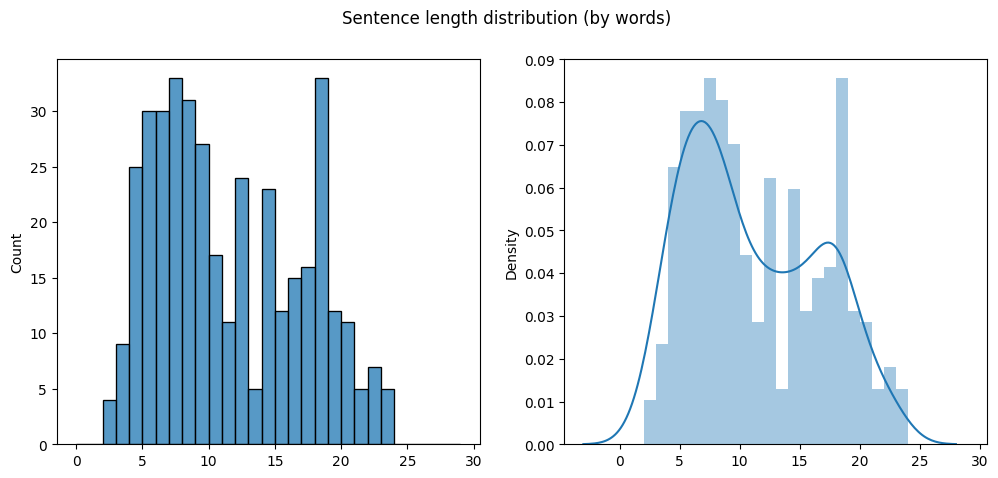

In [156]:
lengths = [len(text.split()) for text in train_df.comment.values]
sizes = [len(text) for text in train_df.comment.values]
hist_plot(lengths, 'Sentence length distribution (by words)')

In [157]:
class Preproccessing:
    def __init__(self):
        self.normalizer_formal = Normalizer(
            correct_spacing=True,
            remove_diacritics=True,
            remove_specials_chars=True,
            decrease_repeated_chars=True,
            seperate_mi=True
        )
        self.normalizer_informal = InformalNormalizer()
        self.lemmatizer = Lemmatizer()

    def train(self, text, string=True):
        strs = ""
        try:
            text = self.normalizer_formal.normalize(text)
            text = self.normalizer_informal.normalize(text)[0]
        except:
            pass
        for i in range(len(text)):
            if len(text[i]) != 1:
                text[i] = [text[i][0]]
            # text[i] = self.lemmatizer.lemmatize(text[i][0]).split("#")[0]
            strs += (text[i][0] + " ")
        if string:
            return re.sub(r'[^\w\s]', ' ', self.normalizer_formal.normalize(strs))
            return self.normalizer_formal.normalize(strs)
        return text

In [158]:
preProcess = Preproccessing()

In [159]:
label = train_df['label']
train_df['sentence'] = train_df['comment'].apply(preProcess.train)

In [160]:
train_df

,comment,label,sentence
0,سفارش داشتم,buying,سفارش داشتم
1,سفارش دارم,buying,سفارش دارم
2,سفارشم رو بگیر,buying,سفارشم را بگیر
3,سفارش من رو ثبت کن,buying,سفارش من را ثبت کن
4,ثبت سفارش کن,buying,ثبت سفارش کن
...,...,...,...
380,باید سفارشمو تغییر بدهم,edit_order,باید سفارشم را تغییر بدهم
381,نظرم عوض شد و میخواهم سفارشم را تغییر بدهم,edit_order,نظرم عوض شد و می خواهم سفارشم را تغییر بدهم
382,چگونه میتونم سفارشم را تغییر بدهم؟,edit_order,چگونه می توانم سفارشم را تغییر بدهم
383,چگونه میتونم سفارشم را دچار تغییر کنم؟,edit_order,چگونه می توانم سفارشم را دچار تغییر کنم


In [161]:
max_features = 5000
maxlen = 30

In [162]:
# tokenize the dataset, it means assign an integer value to the each unique words
# and if the number of occurances of a certain word is more than num_words, ignore tham
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tok.fit_on_texts(list(train_df["sentence"]))

In [163]:
# print number of unique word in our dataset
print(len(tok.word_index))
vocab_szie = len(tok.word_index) + 1

538


In [164]:
# change the words with its index value that comes from tokenizing
train_set = tok.texts_to_sequences(list(train_df["sentence"]))

# make the length of each tokenized vector fixed (maxlen)
train_set = tf.keras.preprocessing.sequence.pad_sequences(train_set, maxlen=maxlen)
x_train, x_test, y_train, y_test = train_test_split(train_set, encodedLabel, test_size=0.1, random_state=12, stratify=encodedLabel)

In [165]:
# x_train, x_test_val, y_train, y_test_val = train_test_split(train_set, label, test_size=0.3, random_state=10)
# x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size = 0.15, random_state=10)
# embedding_dim = 32

In [166]:
embedding_dim = 32

In [167]:
model = Sequential()
model.add(
    tf.keras.layers.Embedding(
        max_features,
        embedding_dim,
        input_length = maxlen
    )
)
model.add(Bidirectional(LSTM(20, activity_regularizer=tf.keras.regularizers.L2(0.1))))
# model.add(Bidirectional(LSTM(20, activity_regularizer=tf.keras.regularizers.L2(0.1))))
# model.add(Bidirectional(LSTM(20, activity_regularizer=tf.keras.regularizers.L2(0.1))))
model.add(Dropout(0.2))
model.add(Dense(numberOfClasses, activation='softmax'))

In [168]:
model.compile(
    optimizer = "adam",
    loss="binary_crossentropy",
    metrics = "accuracy"
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 32)            160000    
                                                                 
 bidirectional_11 (Bidirect  (None, 40)                8480      
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 168726 (659.09 KB)
Trainable params: 168726 (659.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [183]:
result = model.fit(
    x_train,
    y_train,
    validation_data = (x_test, y_test),
    epochs = 5,
    batch_size = 32
    )

Epoch 1/5
11/11 [==============================] - 0s 16ms/step - loss: 0.3228 - accuracy: 0.9971 - val_loss: 0.3378 - val_accuracy: 0.9744
Epoch 2/5
11/11 [==============================] - 0s 12ms/step - loss: 0.3177 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.9744
Epoch 3/5
11/11 [==============================] - 0s 12ms/step - loss: 0.3077 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 0.9744
Epoch 4/5
11/11 [==============================] - 0s 13ms/step - loss: 0.3074 - accuracy: 1.0000 - val_loss: 0.3278 - val_accuracy: 0.9744
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.3039 - accuracy: 1.0000 - val_loss: 0.3242 - val_accuracy: 0.9744


In [184]:
scores = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print("Accuracy: {}%".format(round(scores[1]*100, 2)))

2/2 [==============================] - 0s 0s/step
Accuracy: 97.44%


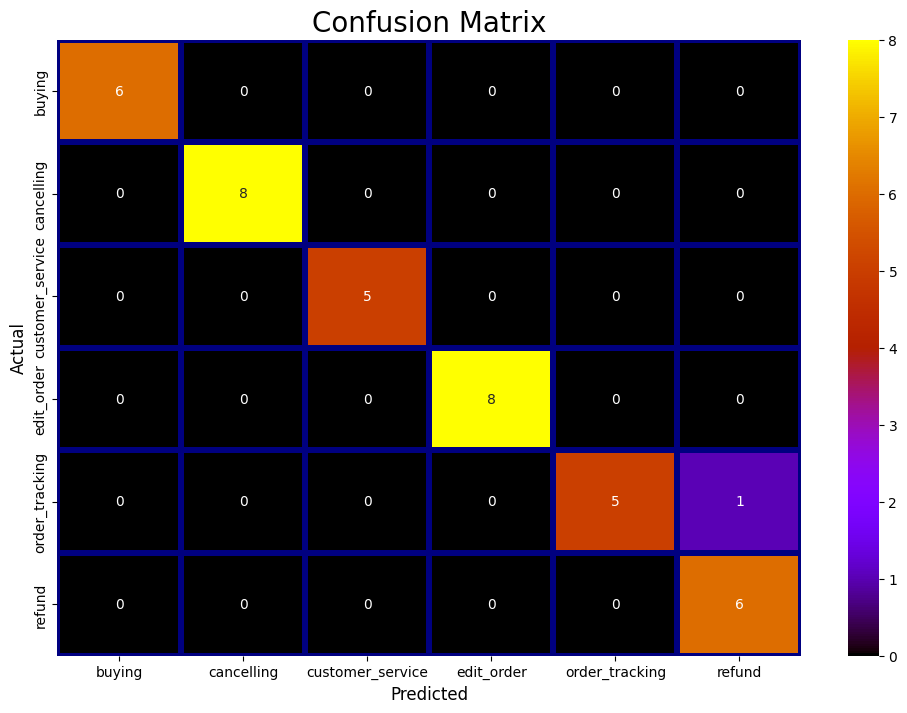

In [185]:
cf = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
label_name = unique_labels
plt.figure(figsize=(12, 8))
sns.heatmap(cf,
            annot=True,
            fmt="d",
            xticklabels=label_name,
            yticklabels=label_name,
            cmap="gnuplot",
            linewidths=3,
            linecolor='navy'
            )
plt.title("Confusion Matrix", fontsize=20, color="black")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

In [186]:
def check_false(y_pred, y_test):
    list = []
    for i in range(len(y_pred.argmax(axis=1))):
        if y_pred.argmax(axis=1)[i] != y_test.argmax(axis=1)[i]:
           list.append((tok.sequences_to_texts([x_test[i]]), y_test.argmax(axis=1)[i], y_pred.argmax(axis=1)[i]))
    return list

In [187]:
check_false(y_pred, y_test)

[(['چه زمانی شماره پیگیری خود را دریافت خواهم کرد'], 4, 5)]

In [174]:
def classify(text):
    text = preProcess.train(text)
    tokenized = tok.texts_to_sequences([text])
    tokenized = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen)
    prediction = model.predict(tokenized)
    print(prediction)
    label = prediction.argmax()
    prediction = encoder.inverse_transform([label])
    return prediction

In [201]:
classify("میخواهم سفارشم را تغییر دهم")

1/1 [==============================] - 0s 23ms/step
[[0.07891347 0.06407762 0.07210085 0.66386545 0.06108305 0.05995955]]


array(['edit_order'], dtype=object)

In [194]:
model.save(r"C:\Users\Win 10\Desktop\ArmanP.rar-20240203T141349Z-001\chatbot-deployment-main\technical_model", save_format="h5")
print('Model Saved!')

c:\Users\Win 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!


In [195]:
import pickle

# saving
with open(r"C:\Users\Win 10\Desktop\ArmanP.rar-20240203T141349Z-001\chatbot-deployment-main\technical_tokenizer.pickle", 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)